## DRACH Motifs

The middle 5-mers of the sequence will always be one of the 18 DRACH motifs.

In [1]:
# Define the possible nucleotides for each position
D = ['A', 'G', 'T']
R = ['A', 'G']
A = ['A']
C = ['C']
H = ['A', 'C', 'T']

# Initialize an empty list to store the DRACH motifs
drach_motifs = []

# Generate all combinations using nested loops
for d in D:
    for r in R: 
        for a in A:
            for c in C:
                for h in H:
                    motif = d + r + a + c + h
                    drach_motifs.append(motif)

# Print the list of DRACH motifs
print(drach_motifs)

['AAACA', 'AAACC', 'AAACT', 'AGACA', 'AGACC', 'AGACT', 'GAACA', 'GAACC', 'GAACT', 'GGACA', 'GGACC', 'GGACT', 'TAACA', 'TAACC', 'TAACT', 'TGACA', 'TGACC', 'TGACT']


## Loading The Data

In [2]:
import gzip
import json
import pandas as pd

### `dataset0.json.gz`

In [3]:
# Function to load data.json.gz file as dataframe
def load_json_gz_to_dataframe(file_path):
    data = []
    with gzip.open(file_path) as f:
        for line in f.readlines():
            json_data = json.loads(line)
            for transcript, positions in json_data.items():
                for position, sequences in positions.items():
                    position = int(position)
                    for sequence, reads in sequences.items():
                        data.append({
                            'transcript_id': transcript,
                            'position': position,
                            'sequence': sequence,
                            "data": reads
                            })
    return pd.DataFrame(data)

In [4]:
# Change the file path to the location of your dataset
file_path = 'dataset0.json.gz'
dataset = load_json_gz_to_dataframe(file_path)
dataset.head(3)

,transcript_id,position,sequence,data
0,ENST00000000233,244,AAGACCA,"[[0.00299, 2.06, 125.0, 0.0177, 10.4, 122.0, 0..."
1,ENST00000000233,261,CAAACTG,"[[0.0126, 1.95, 111.0, 0.0125, 1.27, 108.0, 0...."
2,ENST00000000233,316,GAAACAG,"[[0.00432, 2.02, 104.0, 0.00299, 3.56, 99.3, 0..."


### `data.info.labelled`

In [5]:
# Change the file path to the location of your labels
file_path = 'data.info.labelled'
labels = pd.read_csv(file_path)
labels.head(3)

,gene_id,transcript_id,transcript_position,label
0,ENSG00000004059,ENST00000000233,244,0
1,ENSG00000004059,ENST00000000233,261,0
2,ENSG00000004059,ENST00000000233,316,0


## Exploratory Data Analysis, Feature Engineering & Data Preprocessing

In [6]:
import numpy as np
from matplotlib import pyplot as plt

1. Take the mean of the reads for each row

In [7]:
# Create a copy of the dataset
df = dataset.copy()

# Take the mean of the reads
df['data'] = df['data'].apply(lambda x: np.mean(x, axis=0))
df.head(3)

,transcript_id,position,sequence,data
0,ENST00000000233,244,AAGACCA,"[0.008264378378378385, 4.223783783783786, 123...."
1,ENST00000000233,261,CAAACTG,"[0.006609244186046515, 3.2164244186046504, 109..."
2,ENST00000000233,316,GAAACAG,"[0.0075699999999999995, 2.94054054054054, 105...."


2. Extract the middle 5-mers sequence

In [8]:
# Extract the middle 5-mers sequence
df['sequence'] = df['sequence'].apply(lambda x: x[1:-1])
df.head(3)

,transcript_id,position,sequence,data
0,ENST00000000233,244,AGACC,"[0.008264378378378385, 4.223783783783786, 123...."
1,ENST00000000233,261,AAACT,"[0.006609244186046515, 3.2164244186046504, 109..."
2,ENST00000000233,316,AAACA,"[0.0075699999999999995, 2.94054054054054, 105...."


<Axes: xlabel='sequence'>

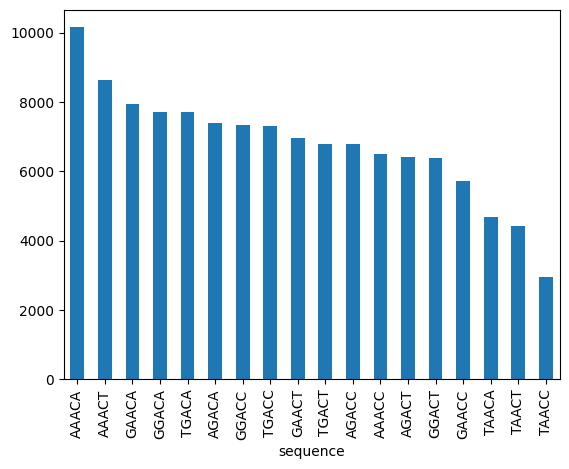

In [9]:
# Plot the distribution of sequence
df['sequence'].value_counts().plot(kind='bar')

3. Perform one-hot encoding on extracted 5-mers sequence

In [10]:
from sklearn.preprocessing import OneHotEncoder

In [11]:
# Initialize the OneHotEncoder with DRACH motifs
encoder = OneHotEncoder(categories=[drach_motifs])

# Fit the encoder to 'sequence' and transform it into a one-hot encoded matrix
one_hot_matrix = encoder.fit_transform(df[['sequence']])

# Convert the one-hot encoded matrix into a column
one_hot_column = pd.Series([list(row) for row in one_hot_matrix.toarray()])

# Concatenate the one-hot encoded column to df
df_encoded = pd.concat([df, one_hot_column.rename('one_hot_encoded')], axis=1)


df_encoded.head(3)

,transcript_id,position,sequence,data,one_hot_encoded
0,ENST00000000233,244,AGACC,"[0.008264378378378385, 4.223783783783786, 123....","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
1,ENST00000000233,261,AAACT,"[0.006609244186046515, 3.2164244186046504, 109...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,ENST00000000233,316,AAACA,"[0.0075699999999999995, 2.94054054054054, 105....","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


4. Inner join the dataset and labels on the transcript id and position

In [12]:
# Inner join df on labels
merged_df = pd.merge(df_encoded, labels,
                     left_on  = ['transcript_id', 'position'],
                     right_on = ['transcript_id', 'transcript_position'],
                     how = 'left')

# Drop the duplicate column and reorder the columns
gene_id = merged_df['gene_id']
merged_df = merged_df.drop(columns=['transcript_position', 'gene_id'])
merged_df.insert(0, 'gene_id', gene_id)

merged_df.head(3)

,gene_id,transcript_id,position,sequence,data,one_hot_encoded,label
0,ENSG00000004059,ENST00000000233,244,AGACC,"[0.008264378378378385, 4.223783783783786, 123....","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",0
1,ENSG00000004059,ENST00000000233,261,AAACT,"[0.006609244186046515, 3.2164244186046504, 109...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
2,ENSG00000004059,ENST00000000233,316,AAACA,"[0.0075699999999999995, 2.94054054054054, 105....","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0


5. Split the dataset into train and test sets by gene_id

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
# Train-test split by gene_id
train_genes, test_genes = train_test_split(labels['gene_id'].unique(), test_size=0.3, random_state=42)

train_df = merged_df[merged_df['gene_id'].isin(train_genes)].copy()
test_df  = merged_df[merged_df['gene_id'].isin(test_genes)].copy()

6. Scale the data

In [15]:
from sklearn.preprocessing import StandardScaler
import joblib

In [16]:
# Extract the lists from the 'data' column
data_lists = np.vstack(train_df['data'].values)

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the data
data_scaled = scaler.fit_transform(data_lists)

# Replace the original 'data' column with the scaled data
train_df['data'] = list(data_scaled)

# scale test data
test_df['data'] = list(scaler.transform(np.vstack(test_df['data'].values)))

# Combine 'data' and 'one_hot_encoded' into a single list for each row
train_df['combined'] = train_df.apply(lambda x: x['data'].tolist() + x['one_hot_encoded'], axis=1)
test_df['combined'] = test_df.apply(lambda x: x['data'].tolist() + x['one_hot_encoded'], axis=1)

# Save the scaler to a file
# joblib.dump(scaler, 'scaler.pkl')

In [17]:
# Get train and test data set
X_train = np.vstack(train_df['combined'].values)
y_train = train_df['label'].values

X_test = np.vstack(test_df['combined'].values)
y_test = test_df['label'].values

7. Apply Synthetic Minority Over-sampling Technique (SMOTE)

In [18]:
from imblearn.over_sampling import SMOTE

In [19]:
# Proportion of positive labels before SMOTE
print(f'Proportion of positive labels before SMOTE: {np.mean(y_train):.4f}')

Proportion of positive labels before SMOTE: 0.0465


In [20]:
# Simulate data with label 1 using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

c:\Users\okk15\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\okk15\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


In [27]:
# Proportion of positive labels after SMOTE
print(f'Proportion of positive labels after SMOTE: {np.mean(y_resampled):.4f}')

Proportion of positive labels after SMOTE: 0.5000


## Baseline Model: Logistic Regression

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

Model Training

In [ ]:
# Initialize the logistic regression model
log_reg_model = LogisticRegression()

# Define the hyperparameters and their values for grid search
param_grid = {
    'C': [0.1, 1, 10, 100],  # C is the inverse of regularization strength
    'penalty': ['l1', 'l2'], # l1 is Lasso, l2 is Ridge
    'solver': ['liblinear']  # 'liblinear' supports both 'l1' and 'l2' penalties
}

# Use GridSearchCV for hyperparameter tuning
# Use average precision as the scoring metric to handle imbalanced data
grid_search = GridSearchCV(log_reg_model, param_grid, cv=5, scoring='average_precision')
grid_search.fit(X_resampled, y_resampled)

# Get the best parameters and the best model
best_params = grid_search.best_params_
best_log_reg_model = grid_search.best_estimator_

print("Best Parameters:", best_params)

# Save the best logistic regression model to a file
# joblib.dump(best_log_reg_model, 'best_log_reg_model.pkl')

Model Evaluation

In [24]:
from sklearn.metrics import average_precision_score, precision_recall_curve, auc

In [25]:
# Create the best logistic regression model if not loaded
# From file
# best_log_reg_model = joblib.load('best_log_reg_model.pkl')

# Best Parameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
best_log_reg_model = LogisticRegression(C=10, penalty='l1', solver='liblinear')

# Fit the model
best_log_reg_model.fit(X_resampled, y_resampled)

LogisticRegression(C=10, penalty='l1', solver='liblinear')

Average Precision Score (Logistic Regression): 0.12584289181909503


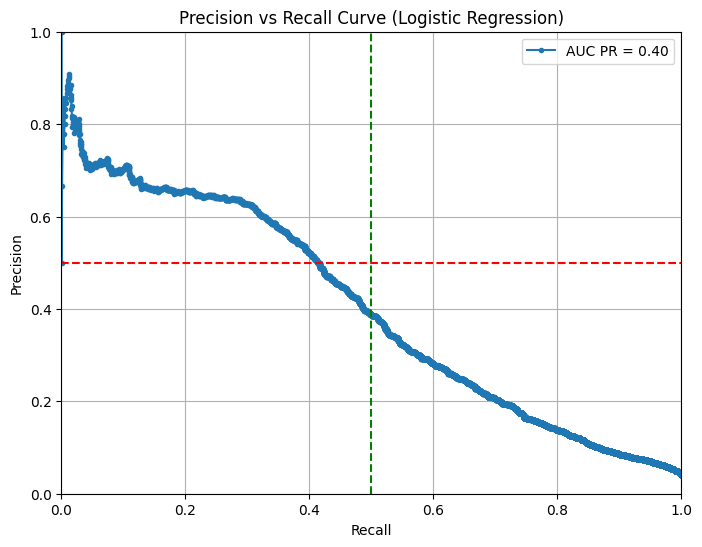

AUC-PR Score (Logistic Regression): 0.4001492283954249


In [26]:
# Get the class prediction
y_pred_lr = best_log_reg_model.predict(X_test)

# Calculate the average precision score
average_precision_lr = average_precision_score(y_test, y_pred_lr)
print("Average Precision Score (Logistic Regression):", average_precision_lr)

# Get the probabilities for the positive class
y_scores_lr = best_log_reg_model.predict_proba(X_test)[:, 1]

# Calculate precision and recall
precision_lr, recall_lr, thresholds_lr = precision_recall_curve(y_test, y_scores_lr)

# Calculate the AUC for the Precision-Recall curve
auc_pr_lr = auc(recall_lr, precision_lr)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall_lr, precision_lr, marker='.', label=f'AUC PR = {auc_pr_lr:.2f}')
plt.title('Precision vs Recall Curve (Logistic Regression)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.axhline(y=0.5, color='r', linestyle='--')  # Reference line for 0.5 precision
plt.axvline(x=0.5, color='g', linestyle='--')  # Reference line for 0.5 recall
plt.legend()
plt.show()

# Print AUC PR score
print("AUC-PR Score (Logistic Regression):", auc_pr_lr)

## Advanced Model: Some neural network

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import AUC

Model Creation

In [22]:
# Create a sequential model
nn_model = Sequential()

# Input layer
nn_model.add(Input(shape=(X_resampled.shape[1],)))

# First hidden layer
nn_model.add(Dense(150, activation='relu'))
nn_model.add(Dropout(0.2))  # Optional: dropout layer for regularization

# Second hidden layer
nn_model.add(Dense(32, activation='relu'))

# Output layer (binary classification)
nn_model.add(Dense(1, activation='sigmoid'))  # Sigmoid activation for binary output

# Compile the model
nn_model.compile(optimizer='adam', 
                 loss='binary_crossentropy', 
                 metrics=['accuracy', AUC(name='auc_pr', curve='PR')])

Model Training

In [23]:
# Save the best model based on validation accuracy
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Fit the model to the training data
nn_model.fit(X_resampled, y_resampled, epochs=10, batch_size=32, validation_split=0.2, callbacks=[checkpoint])  # Adjust epochs and batch_size as needed

# Print model summary
nn_model.summary()

Epoch 1/10
4016/4035 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step - accuracy: 0.7830 - auc_pr: 0.7822 - loss: 0.4520
Epoch 1: val_accuracy improved from -inf to 0.73117, saving model to best_model.keras
4035/4035 ━━━━━━━━━━━━━━━━━━━━ 4s 831us/step - accuracy: 0.7832 - auc_pr: 0.7824 - loss: 0.4518 - val_accuracy: 0.7312 - val_auc_pr: 1.0000 - val_loss: 0.5324
Epoch 2/10
4015/4035 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step - accuracy: 0.8361 - auc_pr: 0.8574 - loss: 0.3729
Epoch 2: val_accuracy improved from 0.73117 to 0.75937, saving model to best_model.keras
4035/4035 ━━━━━━━━━━━━━━━━━━━━ 3s 786us/step - accuracy: 0.8361 - auc_pr: 0.8575 - loss: 0.3729 - val_accuracy: 0.7594 - val_auc_pr: 1.0000 - val_loss: 0.4975
Epoch 3/10
4003/4035 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step - accuracy: 0.8467 - auc_pr: 0.8730 - loss: 0.3487
Epoch 3: val_accuracy did not improve from 0.75937
4035/4035 ━━━━━━━━━━━━━━━━━━━━ 3s 783us/step - accuracy: 0.8467 - auc_pr: 0.8730 - loss: 0.3487 - val_accuracy: 0.7424 - val_auc_pr: 1.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 150)            │         4,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         4,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,197 (106.24 KB)

 Trainable params: 9,065 (35.41 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 18,132 (70.83 KB)

Model Evaluation

1164/1164 ━━━━━━━━━━━━━━━━━━━━ 1s 465us/step


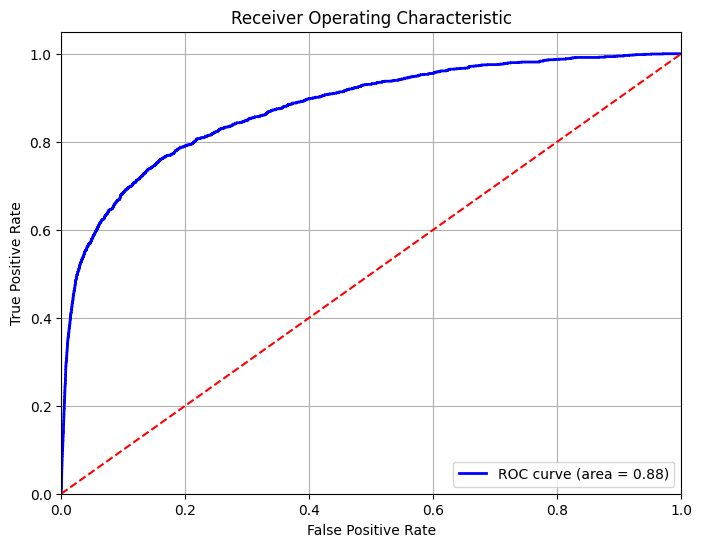

AUC-ROC Score: 0.8773110966504115


In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.models import load_model

# Assuming you have a test set
# X_test: shape (num_samples, 9)
# y_test: shape (num_samples,) with binary labels (0 or 1)
# Make predictions
predictions = nn_model.predict(X_test)

# Get the predicted probabilities for the positive class
predicted_probabilities = predictions

# Calculate the false positive rate and true positive rate
fpr, tpr, _ = roc_curve(y_test, predicted_probabilities)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Print AUC score
print("AUC-ROC Score:", roc_auc)

In [27]:
from sklearn.metrics import average_precision_score, precision_recall_curve, auc

1164/1164 ━━━━━━━━━━━━━━━━━━━━ 1s 452us/step
Average Precision Score (Neural Network): 0.40632514984400026


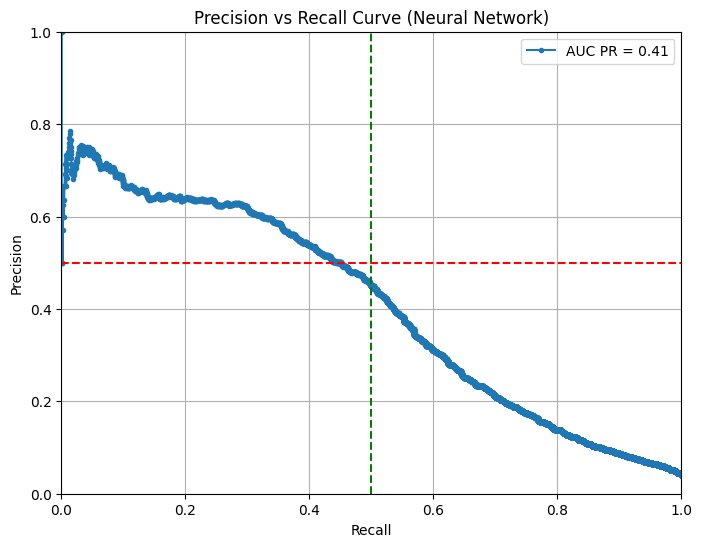

AUC-PR Score (Neural Network): 0.4058106527389288


In [28]:
# Make predictions on the test set using the neural network model
nn_predicted_probabilities = nn_model.predict(X_test).flatten()  # Flatten to 1D array

# Calculate precision, recall, and thresholds for the neural network model
precision_nn, recall_nn, thresholds_nn = precision_recall_curve(y_test, nn_predicted_probabilities)

# Calculate average precision score for the neural network model
average_precision_nn = average_precision_score(y_test, nn_predicted_probabilities)
print("Average Precision Score (Neural Network):", average_precision_nn)

# Calculate the AUC for the Precision-Recall curve for the neural network model
auc_pr_nn = auc(recall_nn, precision_nn)

# Plot Precision-Recall curve for the neural network model
plt.figure(figsize=(8, 6))
plt.plot(recall_nn, precision_nn, marker='.', label=f'AUC PR = {auc_pr_nn:.2f}')
plt.title('Precision vs Recall Curve (Neural Network)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.axhline(y=0.5, color='r', linestyle='--')  # Reference line for 0.5 precision
plt.axvline(x=0.5, color='g', linestyle='--')  # Reference line for 0.5 recall
plt.legend()
plt.show()

# Print AUC PR score for the neural network model
print("AUC-PR Score (Neural Network):", auc_pr_nn)


## Comparing the two models

Average Precision Score for Logistic Regression: 0.126
Average Precision Score for Neural Network: 0.401


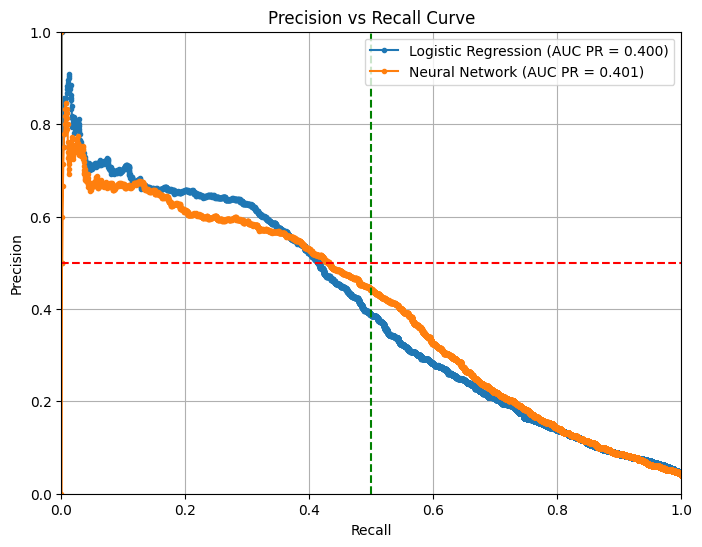

AUC-PR Score for Logistic Regression: 0.4001492283954249
AUC-PR Score for Neural Network: 0.4007461440498518


In [32]:
# Average Precision Scores
print(f"Average Precision Score for Logistic Regression: {average_precision_lr:.3f}")
print(f"Average Precision Score for Neural Network: {average_precision_nn:.3f}")

# Plot both curves
plt.figure(figsize=(8, 6))
plt.plot(recall_lr, precision_lr, marker='.', label=f'Logistic Regression (AUC PR = {auc_pr_lr:.3f})')
plt.plot(recall_nn, precision_nn, marker='.', label=f'Neural Network (AUC PR = {auc_pr_nn:.3f})')
plt.title('Precision vs Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.axhline(y=0.5, color='r', linestyle='--')  # Reference line for 0.5 precision
plt.axvline(x=0.5, color='g', linestyle='--')  # Reference line for 0.5 recall
plt.legend()
plt.show()

# Print AUC PR scores
print("AUC-PR Score for Logistic Regression:", auc_pr_lr)
print("AUC-PR Score for Neural Network:", auc_pr_nn)